# GEE Time Series Data Retrieval

In [ ]:
import geopandas as gpd
import ee
import geemap.foliumap  as geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
plt.style.use('seaborn')

In [13]:
ee.Authenticate()

Enter verification code:  4/1AVHEtk571agN3whIcq4_qEWLu5vb6W6qeOTKR0UDTTYAyC7nSTmLb4o5AU4



Successfully saved authorization token.


In [3]:
ee.Initialize()

## Set up the environment

In [4]:
if 'data' not in os.listdir():
    os.mkdir('data')
    
if 'output' not in os.listdir():
    os.mkdir('output')
    
if 'TS' not in os.listdir('output'):
    os.mkdir('output/TS')

## Cities dataset retrieval and filtering

In [5]:
if 'cities.geojson' not in os.listdir('data'):
    # Read the dataset from url
    cities = gpd.read_file('https://data.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-all-cities-with-a-population-1000@public/exports/geojson?lang=en&timezone=Europe%2FBerlin')
    
    # Filter cities in Latin America with more than 2.5 million inhabitants
    cities = cities[(cities['cou_name_en'] == 'Colombia') & (cities['population'] >= 0.7e6) & (cities.bounds['miny'] < 20)]
    
    cities.to_file('data/cities.geojson', driver = 'GeoJSON')
else:
    # Read dataset directly from path
    cities = gpd.read_file('data/cities.geojson')

## Studied cities visualization

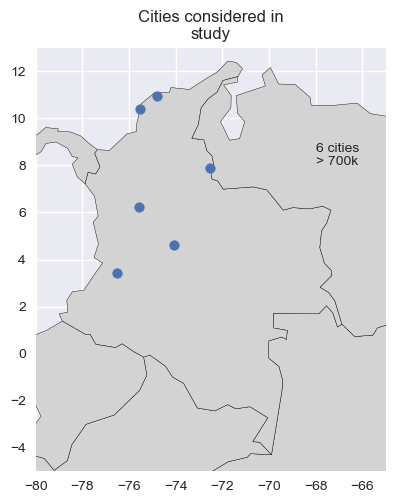

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.geometry.plot(color = 'lightgrey', edgecolor = 'k')

cities.plot(ax= ax)

plt.text(x = -68, y = 8, s = str(len(cities)) + ' cities\n> 700k')

plt.xlim((-80,-65))
plt.ylim((-5,13))


plt.title('Cities considered in\nstudy')

fig = plt.gcf()

fig.savefig('Studied_cities.png')

In [8]:
# Get coordinates from all 12 cities
coords = cities.bounds.iloc[:,:2]
coords.columns = ['Longitude', 'Latitude']

city_names = cities['name'].values

## Time Series Data Retrieval from GEE

In [9]:
# Download the 12 Time Series from Google Earth Engine

# Set dates and point of interest for filtering data
start_date = '2018-07-01'
end_date = '2022-07-01'

for i in range(len(coords)):
    
    poi = ee.Geometry.Point(tuple(coords.iloc[i].values));

    # Get image collections
    S_5P_NO2 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').filterBounds(poi).filterDate(start_date, end_date).select('tropospheric_NO2_column_number_density')
    S_5P_SO2 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_SO2').filterBounds(poi).filterDate(start_date, end_date).select('SO2_column_number_density')
    S_5P_PM = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_AER_AI').filterBounds(poi).filterDate(start_date, end_date).select('absorbing_aerosol_index')
    
        
    def get_TimeSeries(img_col, poi):
        S5_u_poi = img_col.getRegion(poi, scale = 10000).getInfo()

        TS = pd.DataFrame(S5_u_poi[1:]).dropna()
        TS.columns = S5_u_poi[0]
        TS['value'] = TS.iloc[:,4]
        TS['Date'] = TS['id'].apply(lambda df : pd.to_datetime(df[:15], format = '%Y%m%dT%H%M%S'))

        TS = TS[['Date','value']]

        return TS

    TS_N = get_TimeSeries(S_5P_NO2, poi)
    TS_S = get_TimeSeries(S_5P_SO2, poi)
    TS_PM =  get_TimeSeries(S_5P_PM, poi)
    
    # Export timeseries as csv files
    TS_N.to_csv('output/TS/'+city_names[i]+'_NO2_TimeSeries.csv')
    TS_S.to_csv('output/TS/'+city_names[i]+'_SO2_TimeSeries.csv')
    TS_PM.to_csv('output/TS/'+city_names[i]+'_AER_TimeSeries.csv')

## Bi-Temporal Analysis for NO2

In [10]:
dates_2019 = ['2019-03-01', '2019-05-01']

dates_2020 = ['2020-03-01', '2020-05-01']

dates_2021 = ['2021-03-01', '2021-05-01']

Study_Cities = ee.Geometry.MultiPoint(coords = list(coords.apply(lambda df: [df.iloc[0], df.iloc[1]], axis = 1)))

S_5P_2019 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').filterBounds(Study_Cities).filterDate(dates_2019[0], dates_2019[1]).select('tropospheric_NO2_column_number_density').mean().clip(Study_Cities.buffer(10000))
S_5P_2020 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').filterBounds(Study_Cities).filterDate(dates_2020[0], dates_2020[1]).select('tropospheric_NO2_column_number_density').mean().clip(Study_Cities.buffer(10000))
S_5P_2021 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').filterBounds(Study_Cities).filterDate(dates_2021[0], dates_2021[1]).select('tropospheric_NO2_column_number_density').mean().clip(Study_Cities.buffer(10000))

Map = geemap.Map()

vis = {'min': 0,
       'max': 0.00015,
       'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

Map.addLayer(S_5P_2019, vis,'NO2 2019')
Map.addLayer(S_5P_2020, vis,'NO2 2020')
Map.addLayer(S_5P_2021, vis,'NO2 2021')

Map.centerObject(Study_Cities, zoom = 7)
Map.addLayer(Study_Cities, name = 'cities')

Map

In [13]:
Map.to_html(filename='output/NO2_AQ_Colombia.html', title='NO2_Colombia', width='100%', height='880px')